In [1]:
import cupy
import numpy
import math
import matplotlib.pyplot as plt

Wait until conda gets 5.0 if you want RawKernel. Not fun to setup CUDA with libraries and build. All credit for original code codes to Jim Pivarski here: https://github.com/jpivarski/python-numpy-mini-course/blob/evaluated/7-gpu.ipynb

In [2]:
cupy.__version__

'5.0.0'

In [3]:
import numpy

def prepare(height, width, numpy=numpy):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)
    return c, fractal

def run(c, fractal, maxiterations=20):
    fractal *= 0                  # set fractal to maxiterations without replacing it
    fractal += maxiterations
    z = c
    for i in range(maxiterations):
        z **= 2
        z += c
        diverge = z.real**2 + z.imag**2 > 2**2
        z[diverge] = 2
        diverge &= (fractal == maxiterations)
        fractal[diverge] = i
        
    return fractal

In [4]:
c, fractal = prepare(800*2, 1200*2, numpy)

In [5]:
%%timeit
_ = run(c, fractal)

973 ms ± 64.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
c, fractal = prepare(800*2, 1200*2, cupy)

In [7]:
%%timeit
_ = run(c, fractal)

38.7 ms ± 96 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
cupy_single = cupy.ElementwiseKernel(
    "complex128 cpx, int32 maxiterations",
    "int32 res",
    """
    res = maxiterations;
    complex<double> z = cpx;
    
    for (int i=0; i<maxiterations; i++) {
        z = z*z + cpx;
        
        if(z.real()*z.real() + z.imag()*z.imag() > 4) {
            res = i;
            break;
        }
    }
    
    """,                                
    "fract_el")

In [9]:
c, _ = prepare(800*2, 1200*2, cupy)

In [10]:
%%timeit
fractal = cupy_single(c, 20)

162 µs ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
cupy_kernel = cupy.RawKernel("""
extern "C" 
__global__ void fractal(double* c, int* fractal, int height, int width, int maxiterations) {
    const int x = threadIdx.x + blockIdx.x*blockDim.x;
    const int y = threadIdx.y + blockIdx.y*blockDim.y;
    double creal = c[2 * (x + height*y)];
    double cimag = c[2 * (x + height*y) + 1];
    double zreal = creal;
    double zimag = cimag;
    fractal[x + height*y] = maxiterations;
    for (int i = 0;  i < maxiterations;  i++) {
        double zreal2 = zreal*zreal - zimag*zimag + creal;
        double zimag2 = 2*zreal*zimag + cimag;
        zreal = zreal2;
        zimag = zimag2;
        if (zreal*zreal + zimag*zimag > 4) {
            fractal[x + height*y] = i;
            break;
        }
    }
}
""", "fractal")

In [12]:
def run_pycuda(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    grid = (int(math.ceil(height / 32)), int(math.ceil(width / 32)))
    c = x + y*1j
    fractal = cupy.empty(c.shape, dtype=cupy.int32) + maxiterations
    cupy_kernel(grid, (32,32,1),
                [c.view(cupy.double), fractal,
                cupy.int32(height),
                cupy.int32(width),
                cupy.int32(maxiterations)])
    return c, fractal

In [13]:
%%timeit
_, fractal = run_pycuda(800*2, 1200*2)    # Someone else is on my GPU

998 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


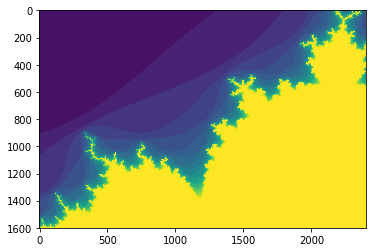

In [14]:
_, fractal = run_pycuda(800*2, 1200*2)
plt.imshow(fractal.get())